https://www.kaggle.com/code/mahmoud87hassan/predict-future-crude-oil-prices-using-lstm-network/notebook

In [283]:
import numpy as np # linear algebra
from numpy import array
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import datetime
from pylab import rcParams
import matplotlib.pyplot as plt
import warnings
import itertools
import statsmodels.api as sm
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from sklearn import metrics
from sklearn.metrics import mean_squared_error
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from keras.preprocessing.sequence import TimeseriesGenerator
import seaborn as sns
sns.set_context("paper", font_scale=1.3)
sns.set_style('white')
import math
from sklearn.preprocessing import MinMaxScaler
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')
import os

Mengkonversi kolom tanggal ke format tertentu (d,m,Y)

In [284]:
#Convert date coulmns to specific format
dateparse = lambda x: pd.datetime.strptime(x, '%d/%m/%Y')

In [285]:
path = "/content/drive/MyDrive/TugasAkhir/"

In [286]:
from google.colab import drive
drive.mount('/content/drive')
df = pd.read_csv(path+"Data_Minyak.csv", sep =";", parse_dates=['Date'], date_parser=dateparse)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [287]:
#Sort dataset by column Date
df = df.sort_values('Date')
df = df.groupby('Date')['Price'].sum().reset_index()
df.set_index('Date', inplace=True)
df=df.loc[datetime.date(year=2019,month=1,day=2):]

In [288]:
# Print some data rows.
df.head()

,Price
Date,
2019-01-02,13900
2019-01-03,13900
2019-01-04,13900
2019-01-07,13900
2019-01-08,13900


In [289]:
#Read dataframe info
def DfInfo(df_initial):
    # gives some infos on columns types and numer of null values
    tab_info = pd.DataFrame(df_initial.dtypes).T.rename(index={0: 'column type'})
    tab_info = tab_info.append(pd.DataFrame(df_initial.isnull().sum()).T.rename(index={0: 'null values (nb)'}))
    tab_info = tab_info.append(pd.DataFrame(df_initial.isnull().sum() / df_initial.shape[0] * 100).T.
                               rename(index={0: 'null values (%)'}))
    return tab_info

In [290]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1024 entries, 2019-01-02 to 2023-03-01
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   Price   1024 non-null   int64
dtypes: int64(1)
memory usage: 16.0 KB


In [291]:
df.index

DatetimeIndex(['2019-01-02', '2019-01-03', '2019-01-04', '2019-01-07',
               '2019-01-08', '2019-01-09', '2019-01-10', '2019-01-11',
               '2019-01-14', '2019-01-15',
               ...
               '2023-02-16', '2023-02-17', '2023-02-20', '2023-02-21',
               '2023-02-22', '2023-02-23', '2023-02-24', '2023-02-27',
               '2023-02-28', '2023-03-01'],
              dtype='datetime64[ns]', name='Date', length=1024, freq=None)

In [292]:
y = df['Price'].resample('MS').mean()

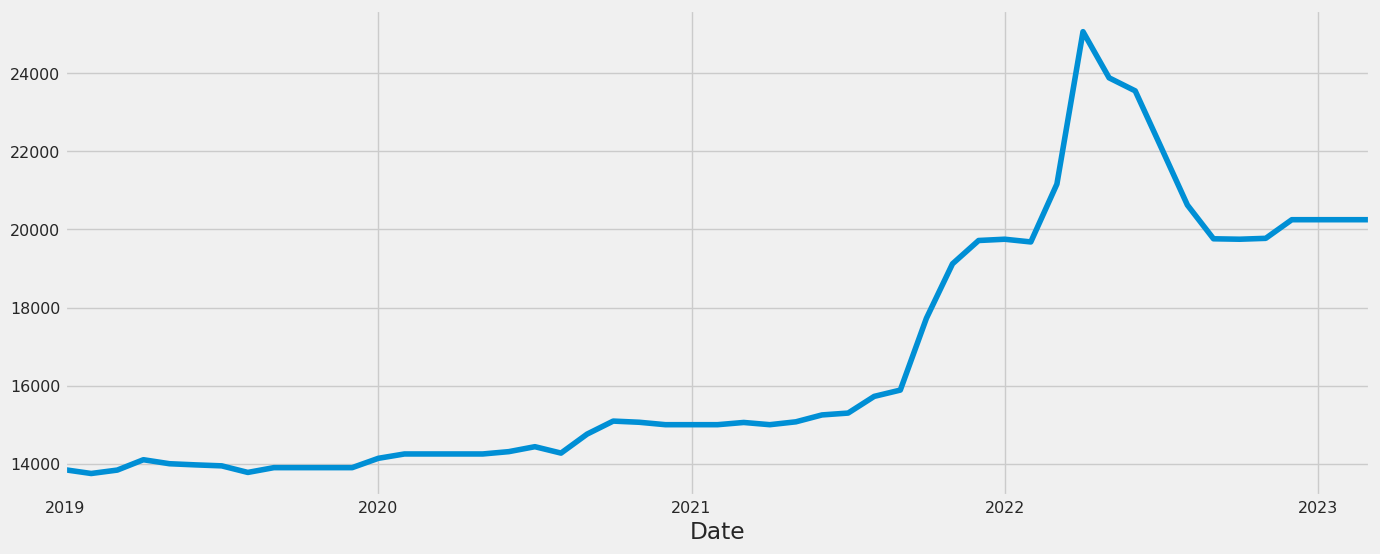

In [293]:
y.plot(figsize=(15, 6))
plt.show()

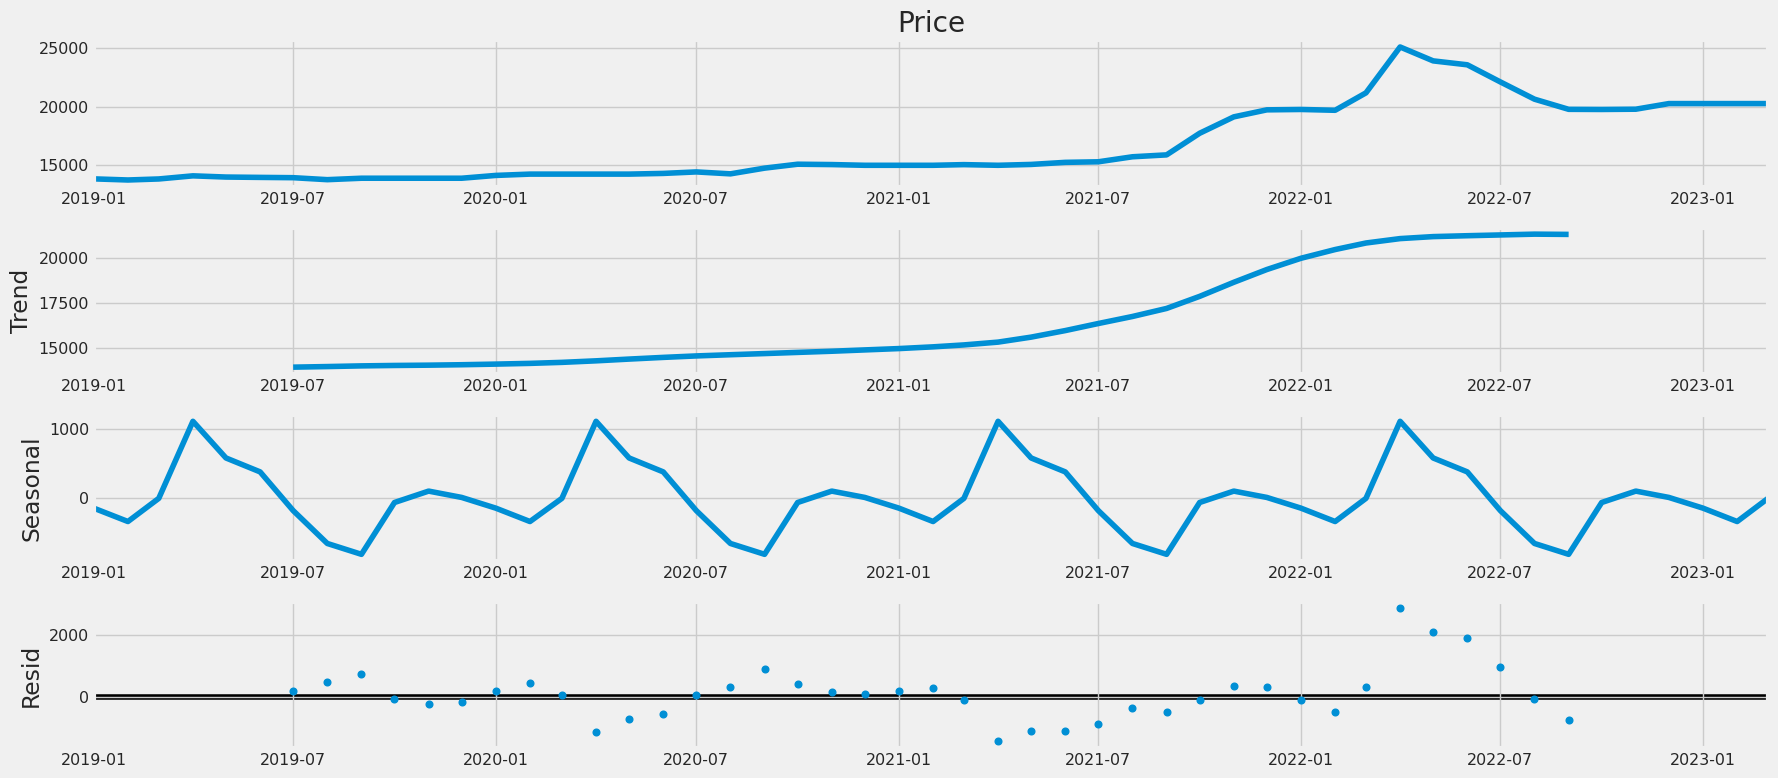

In [294]:
rcParams['figure.figsize'] = 18, 8
decomposition =sm.tsa.seasonal_decompose(y, model = 'additive')
fig = decomposition.plot()
plt.show()

In [295]:
# normalize the data_set
sc = MinMaxScaler(feature_range = (0, 1))
df = sc.fit_transform(df)

In [296]:
print(df)

[[0.01945525]
 [0.01945525]
 [0.01945525]
 ...
 [0.51361868]
 [0.51361868]
 [0.51361868]]


In [297]:
len(df)

1024

In [298]:
# split into train and test sets
train_size = int(len(df) * 0.80)
test_size = len(df) - train_size
train, test = df[0:train_size, :], df[train_size:len(df), :]

In [299]:
# convert an array of values into a data_set matrix def
def create_data_set(_data_set, _look_back=1):
    data_x, data_y = [], []
    for i in range(len(_data_set) - _look_back - 1):
        a = _data_set[i:(i + _look_back), 0]
        data_x.append(a)
        data_y.append(_data_set[i + _look_back, 0])
    return np.array(data_x), np.array(data_y)

In [300]:
# reshape into X=t and Y=t+1
look_back =4
X_train,Y_train,X_test,Ytest = [],[],[],[]
X_train,Y_train=create_data_set(train,look_back)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test,Y_test=create_data_set(test,look_back)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [301]:
# hyperparameter tuning
repeats = 3
trainScore0 = 100000
listTrainScore = []
for i in range(repeats):
  print('Training ke-' + str(i+1))

  # create and fit the LSTM network regressor1 = Sequential()
  regressor1 = Sequential()

  regressor1.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
  regressor1.add(Dropout(0.05))

  regressor1.add(LSTM(units = 50, return_sequences = True))
  regressor1.add(Dropout(0.05))

  regressor1.add(LSTM(units = 50))
  regressor1.add(Dropout(0.05))

  regressor1.add(Dense(units = 1))

  regressor1.compile(optimizer = 'adam', loss = 'mean_squared_error')
  reduce_lr = ReduceLROnPlateau(monitor='val_loss',patience=10)

  history1 = regressor1.fit(X_train, Y_train, epochs = 266, batch_size = 64,validation_data=(X_test, Y_test), callbacks=[reduce_lr],shuffle=False)

  train_predict = regressor1.predict(X_train)
  train_predict1 = sc.inverse_transform(train_predict)
  Y_train1 = sc.inverse_transform([Y_train])

  trainScore = metrics.mean_squared_error(Y_train1[0], train_predict1[:,0]) ** .5
  print('\ntrain score ke-' + str(i+1) + ' = ' + str(trainScore))
  listTrainScore.append(trainScore)

  if trainScore0 > trainScore:
    # memilih model yang memiliki performa terbaik
    regressor = regressor1
    history = history1
    trainScore0 = trainScore
  print('')

Training ke-1
Epoch 1/266
13/13 [==============================] - 10s 251ms/step - loss: 0.0361 - val_loss: 0.1742 - lr: 0.0010
Epoch 2/266
13/13 [==============================] - 0s 20ms/step - loss: 0.0311 - val_loss: 0.1204 - lr: 0.0010
Epoch 3/266
13/13 [==============================] - 0s 22ms/step - loss: 0.0294 - val_loss: 0.0926 - lr: 0.0010
Epoch 4/266
13/13 [==============================] - 0s 20ms/step - loss: 0.0227 - val_loss: 0.0599 - lr: 0.0010
Epoch 5/266
13/13 [==============================] - 0s 21ms/step - loss: 0.0124 - val_loss: 0.0181 - lr: 0.0010
Epoch 6/266
13/13 [==============================] - 0s 24ms/step - loss: 0.0043 - val_loss: 0.0011 - lr: 0.0010
Epoch 7/266
13/13 [==============================] - 0s 23ms/step - loss: 0.0017 - val_loss: 0.0019 - lr: 0.0010
Epoch 8/266
13/13 [==============================] - 0s 19ms/step - loss: 0.0011 - val_loss: 9.0097e-04 - lr: 0.0010
Epoch 9/266
13/13 [==============================] - 0s 21ms/step - loss: 0.

In [302]:
print('3 nilai RSME pada 3 kali training model:')
listTrainScore

3 nilai RSME pada 3 kali training model:


[312.1037514853665, 309.15919505515944, 307.0032536434163]

In [303]:
print('nilai RSME terbaik =', min(listTrainScore))

nilai RSME terbaik = 307.0032536434163


In [304]:
train_predict = regressor.predict(X_train)
test_predict = regressor.predict(X_test)

7/7 [==============================] - 0s 6ms/step


In [305]:
# invert predictions
train_predict1 = sc.inverse_transform(train_predict)
Y_train1 = sc.inverse_transform([Y_train])
test_predict1 = sc.inverse_transform(test_predict)
Y_test1 = sc.inverse_transform([Y_test])

In [306]:
trainScore = metrics.mean_squared_error(Y_train1[0], train_predict1[:,0]) ** .5
print('Train Score: %.2f RMSE' % (trainScore))
testScore = metrics.mean_squared_error(Y_test1[0], test_predict1[:,0]) ** .5
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 307.00 RMSE
Test Score: 368.99 RMSE


Train Mean Absolute Error: 110.77694304745063
Train Root Mean Squared Error: 307.0032536434163
Test Mean Absolute Error: 223.789072265625
Test Root Mean Squared Error: 368.98514662124944


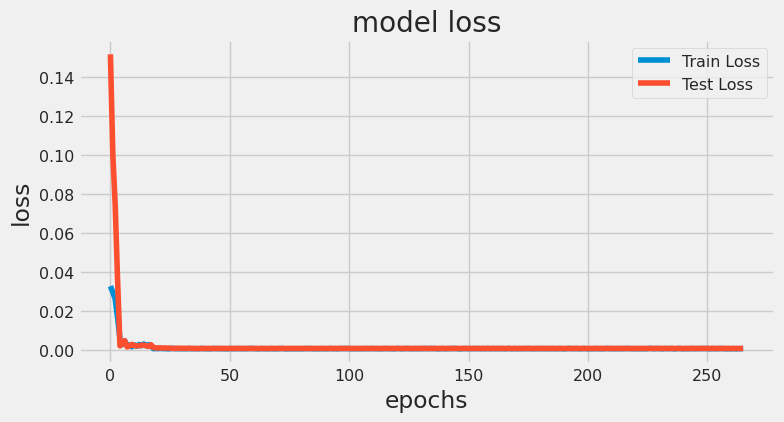

In [307]:
print('Train Mean Absolute Error:', mean_absolute_error(Y_train1[0], train_predict1[:,0]))
print('Train Root Mean Squared Error:',np.sqrt(mean_squared_error(Y_train1[0], train_predict1[:,0])))
print('Test Mean Absolute Error:', mean_absolute_error(Y_test1[0], test_predict1[:,0]))
print('Test Root Mean Squared Error:',np.sqrt(mean_squared_error(Y_test1[0], test_predict1[:,0])))
plt.figure(figsize=(8,4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(loc='upper right')
plt.show();

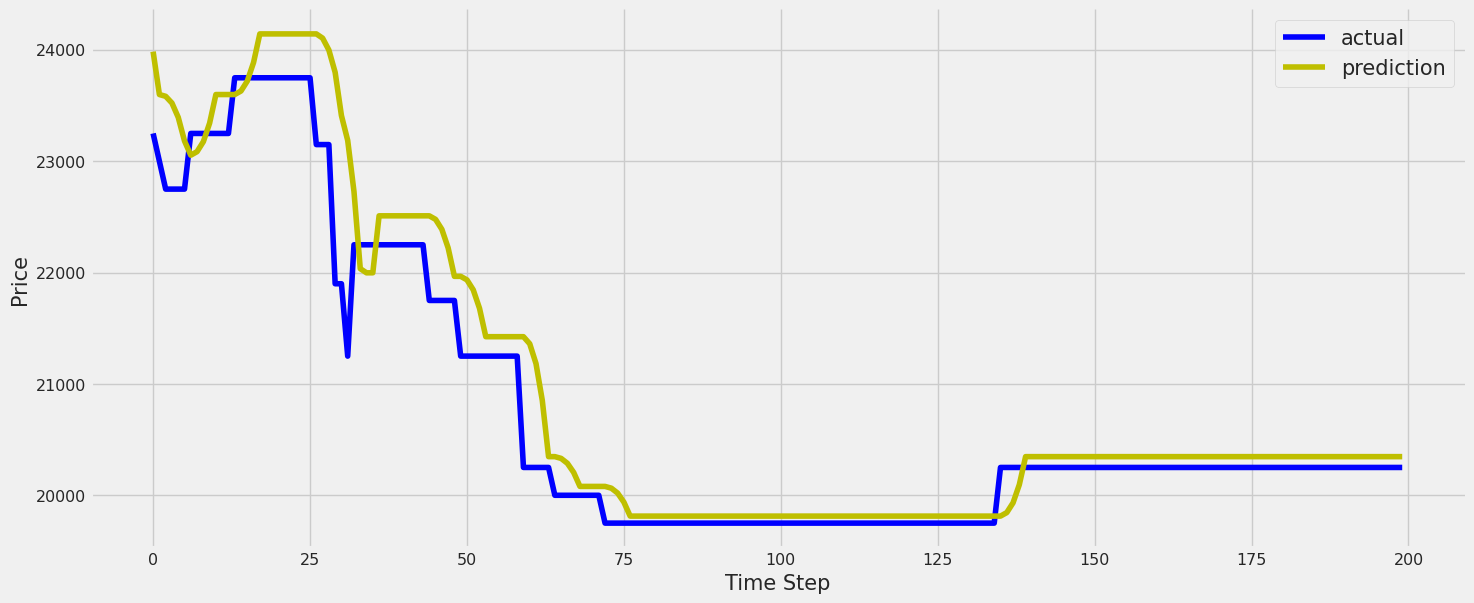

In [308]:
#Compare Actual vs. Prediction
aa=[x for x in range(180)]
plt.figure(figsize=(15,6))
plt.plot(Y_test1[0], 'b', label="actual")
plt.plot(test_predict1, 'y', label="prediction")
plt.tight_layout()
sns.despine(top=True)
plt.subplots_adjust(left=0.07)
plt.ylabel('Price', size=15)
plt.xlabel('Time Step', size=15)
plt.legend(fontsize=15)
plt.show()

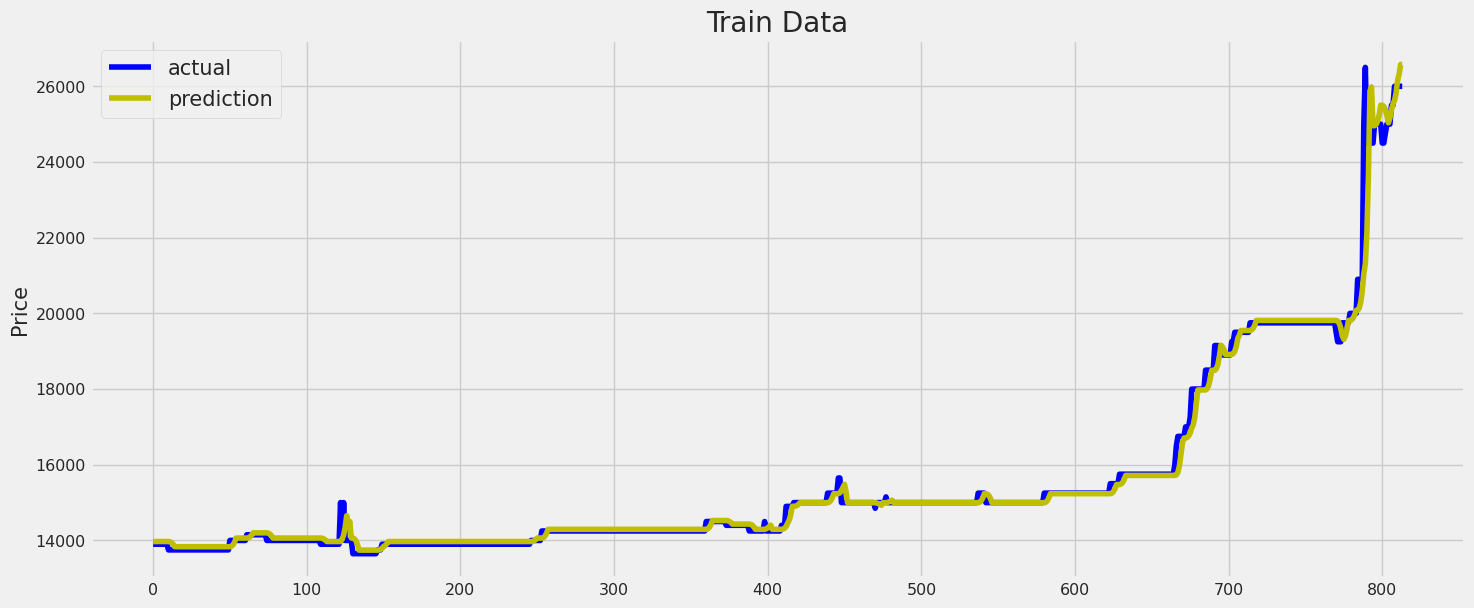

In [309]:
# Compare train data Actual vs. Prediction
plt.style.context("seaborn-white")
plt.figure(figsize=(15,6))
plt.plot(Y_train1[0], 'b', label="actual")
plt.plot(train_predict1, 'y', label="prediction")
plt.tight_layout()
plt.title('Train Data')
# sns.despine(top=True)
plt.subplots_adjust(left=0.07)
plt.ylabel('Price', size=15)
plt.legend(fontsize=15)
plt.show();

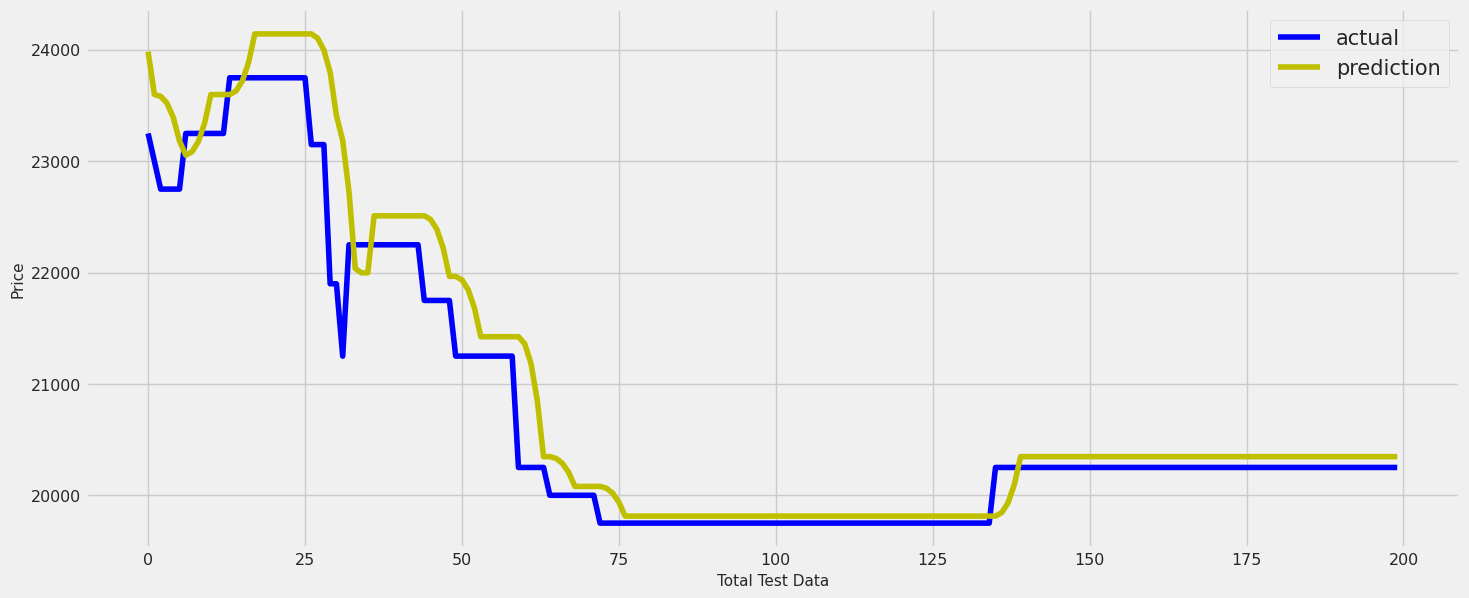

In [310]:
# Compare test data Actual vs. Prediction
plt.figure(figsize=(15,6))
plt.plot(Y_test1[0], 'b', label="actual")
plt.plot(test_predict1, 'y', label="prediction")
plt.tight_layout()
# sns.despine(top=True)
plt.subplots_adjust(left=0.07)
plt.ylabel('Price', size=11)
plt.xlabel('Total Test Data', size=11)
plt.legend(fontsize=15)
plt.show();

In [311]:
train_predict2 = train_predict1.T
train_predict2 = list(train_predict2[0])
print(train_predict2)

[13971.164, 13971.164, 13971.164, 13971.164, 13971.164, 13971.164, 13971.164, 13971.164, 13971.164, 13971.164, 13971.164, 13963.313, 13941.104, 13899.398, 13834.399, 13834.399, 13834.399, 13834.399, 13834.399, 13834.399, 13834.399, 13834.399, 13834.399, 13834.399, 13834.399, 13834.399, 13834.399, 13834.399, 13834.399, 13834.399, 13834.399, 13834.399, 13834.399, 13834.399, 13834.399, 13834.399, 13834.399, 13834.399, 13834.399, 13834.399, 13834.399, 13834.399, 13834.399, 13834.399, 13834.399, 13834.399, 13834.399, 13834.399, 13834.399, 13834.399, 13834.399, 13847.408, 13884.316, 13953.865, 14062.762, 14062.762, 14062.762, 14062.762, 14062.762, 14062.762, 14062.762, 14062.762, 14070.658, 14093.0205, 14135.075, 14200.783, 14200.783, 14200.783, 14200.783, 14200.783, 14200.783, 14200.783, 14200.783, 14200.783, 14200.783, 14192.84, 14170.395, 14128.299, 14062.762, 14062.762, 14062.762, 14062.762, 14062.762, 14062.762, 14062.762, 14062.762, 14062.762, 14062.762, 14062.762, 14062.762, 14062.762

In [312]:
test_predict2 = test_predict1.T
test_predict2 = list(test_predict2[0])
print(test_predict2)

[23984.834, 23599.42, 23583.537, 23522.95, 23394.791, 23182.943, 23054.594, 23086.422, 23175.807, 23342.559, 23599.42, 23599.42, 23599.42, 23599.42, 23631.14, 23720.38, 23887.09, 24144.023, 24144.023, 24144.023, 24144.023, 24144.023, 24144.023, 24144.023, 24144.023, 24144.023, 24144.023, 24106.05, 23998.984, 23798.758, 23410.834, 23186.984, 22728.14, 22035.57, 21998.143, 21998.428, 22510.115, 22510.115, 22510.115, 22510.115, 22510.115, 22510.115, 22510.115, 22510.115, 22510.115, 22478.182, 22388.695, 22222.195, 21966.555, 21966.555, 21934.623, 21845.268, 21679.238, 21424.496, 21424.496, 21424.496, 21424.496, 21424.496, 21424.496, 21424.496, 21360.701, 21182.545, 20852.334, 20347.182, 20347.182, 20331.357, 20287.21, 20205.334, 20079.686, 20079.686, 20079.686, 20079.686, 20079.686, 20063.906, 20019.896, 19938.295, 19813.062, 19813.062, 19813.062, 19813.062, 19813.062, 19813.062, 19813.062, 19813.062, 19813.062, 19813.062, 19813.062, 19813.062, 19813.062, 19813.062, 19813.062, 19813.062, 

In [313]:
#Sort dataset by column Date
df = pd.read_csv(path+"Data_Minyak.csv", sep =";", parse_dates=['Date'], date_parser=dateparse)
df = df.sort_values('Date')
df = df.groupby('Date')['Price'].sum().reset_index()
df.set_index('Date', inplace=True)
df=df.loc[datetime.date(year=2019,month=1,day=2):]

In [314]:
# tabel untuk data train beserta hasil prediksinya
df_train = df[:len(train_predict2)]
df_train['Predictions'] = train_predict2
df_train

,Price,Predictions
Date,,
2019-01-02,13900,13971.164062
2019-01-03,13900,13971.164062
2019-01-04,13900,13971.164062
2019-01-07,13900,13971.164062
2019-01-08,13900,13971.164062
...,...,...
2022-04-21,25000,25815.800781
2022-04-22,25500,26158.416016
2022-04-25,25500,26322.824219


In [315]:
# tabel untuk data test beserta hasil prediksinya
df_test = df[-(len(test_predict2)):]
df_test['Predictions'] = test_predict2
df_test

,Price,Predictions
Date,,
2022-05-23,23000,23984.833984
2022-05-24,22750,23599.419922
2022-05-25,22750,23583.537109
2022-05-27,22750,23522.949219
2022-05-30,22750,23394.791016
...,...,...
2023-02-23,20250,20347.181641
2023-02-24,20250,20347.181641
2023-02-27,20250,20347.181641


In [ ]:
df_100.to_csv('Data_Minyak.csv')

### Predict 100 days later

In [316]:
len(test)

205

In [317]:
date = np.array('2023-03-02', dtype=np.datetime64)
date

array('2023-03-02', dtype='datetime64[D]')

In [318]:
date = date + np.arange(100)

In [319]:
x_input = test[105:].reshape(1,-1)
x_input.shape

(1, 100)

In [320]:
x_input

array([[0.47470817, 0.47470817, 0.47470817, 0.47470817, 0.47470817,
        0.47470817, 0.47470817, 0.47470817, 0.47470817, 0.47470817,
        0.47470817, 0.47470817, 0.47470817, 0.47470817, 0.47470817,
        0.47470817, 0.47470817, 0.47470817, 0.47470817, 0.47470817,
        0.47470817, 0.47470817, 0.47470817, 0.47470817, 0.47470817,
        0.47470817, 0.47470817, 0.47470817, 0.47470817, 0.47470817,
        0.47470817, 0.47470817, 0.47470817, 0.47470817, 0.51361868,
        0.51361868, 0.51361868, 0.51361868, 0.51361868, 0.51361868,
        0.51361868, 0.51361868, 0.51361868, 0.51361868, 0.51361868,
        0.51361868, 0.51361868, 0.51361868, 0.51361868, 0.51361868,
        0.51361868, 0.51361868, 0.51361868, 0.51361868, 0.51361868,
        0.51361868, 0.51361868, 0.51361868, 0.51361868, 0.51361868,
        0.51361868, 0.51361868, 0.51361868, 0.51361868, 0.51361868,
        0.51361868, 0.51361868, 0.51361868, 0.51361868, 0.51361868,
        0.51361868, 0.51361868, 0.51361868, 0.51

In [321]:
temp_input=list(x_input)
temp_input=temp_input[0].tolist()

In [322]:
temp_input

[0.47470817120622577,
 0.47470817120622577,
 0.47470817120622577,
 0.47470817120622577,
 0.47470817120622577,
 0.47470817120622577,
 0.47470817120622577,
 0.47470817120622577,
 0.47470817120622577,
 0.47470817120622577,
 0.47470817120622577,
 0.47470817120622577,
 0.47470817120622577,
 0.47470817120622577,
 0.47470817120622577,
 0.47470817120622577,
 0.47470817120622577,
 0.47470817120622577,
 0.47470817120622577,
 0.47470817120622577,
 0.47470817120622577,
 0.47470817120622577,
 0.47470817120622577,
 0.47470817120622577,
 0.47470817120622577,
 0.47470817120622577,
 0.47470817120622577,
 0.47470817120622577,
 0.47470817120622577,
 0.47470817120622577,
 0.47470817120622577,
 0.47470817120622577,
 0.47470817120622577,
 0.47470817120622577,
 0.5136186770428017,
 0.5136186770428017,
 0.5136186770428017,
 0.5136186770428017,
 0.5136186770428017,
 0.5136186770428017,
 0.5136186770428017,
 0.5136186770428017,
 0.5136186770428017,
 0.5136186770428017,
 0.5136186770428017,
 0.5136186770428017,


In [323]:
pred_100=[]
n_steps=100
i=0
while(i<100):

    if(len(temp_input)>100):
      x_input=np.array(temp_input[1:])
      print("{} day input {}".format(i,x_input))
      x_input=x_input.reshape(1,-1)
      x_input = x_input.reshape((1, n_steps, 1))

      pred_new = regressor.predict(x_input)
      print("{} day output {}".format(i,pred_new))
      temp_input.extend((pred_new[0]/10).tolist())
      temp_input=temp_input[1:]

      pred_100.extend(pred_new.tolist())
      i=i+1
    else:
      x_input = x_input.reshape((1, n_steps,1))
      pred_new = regressor.predict(x_input)
      print(pred_new[0])
      temp_input.extend(pred_new[0].tolist())
      print(len(temp_input))
      pred_100.extend(pred_new.tolist())
      i=i+1

print(pred_100)

1/1 [==============================] - 1s 1s/step
[5.2110267]
101
1 day input [0.47470817 0.47470817 0.47470817 0.47470817 0.47470817 0.47470817
 0.47470817 0.47470817 0.47470817 0.47470817 0.47470817 0.47470817
 0.47470817 0.47470817 0.47470817 0.47470817 0.47470817 0.47470817
 0.47470817 0.47470817 0.47470817 0.47470817 0.47470817 0.47470817
 0.47470817 0.47470817 0.47470817 0.47470817 0.47470817 0.47470817
 0.47470817 0.47470817 0.47470817 0.51361868 0.51361868 0.51361868
 0.51361868 0.51361868 0.51361868 0.51361868 0.51361868 0.51361868
 0.51361868 0.51361868 0.51361868 0.51361868 0.51361868 0.51361868
 0.51361868 0.51361868 0.51361868 0.51361868 0.51361868 0.51361868
 0.51361868 0.51361868 0.51361868 0.51361868 0.51361868 0.51361868
 0.51361868 0.51361868 0.51361868 0.51361868 0.51361868 0.51361868
 0.51361868 0.51361868 0.51361868 0.51361868 0.51361868 0.51361868
 0.51361868 0.51361868 0.51361868 0.51361868 0.51361868 0.51361868
 0.51361868 0.51361868 0.51361868 0.51361868 0.5136

In [ ]:
pred_100 = np.array(pred_100)/10

In [ ]:
pred_100_inv = sc.inverse_transform(pred_100)

In [326]:
df_100 = pd.DataFrame(pred_100_inv, columns=['prediction 100'])
df_100.set_index(date)

,prediction 100
2023-03-02,20346.169269
2023-03-03,20357.572281
2023-03-04,20365.763946
2023-03-05,20367.820899
2023-03-06,20368.991838
...,...
2023-06-05,20347.239718
2023-06-06,20347.238493
2023-06-07,20347.238493
2023-06-08,20347.239718


In [330]:
df_100.to_csv('Prediksi_Minyak_100.csv')

In [327]:
day_test = np.arange(1, len(df_test['Price'])+1)
day_100 = np.arange(len(df_test['Price'])+1, len(df_test['Price'])+101)

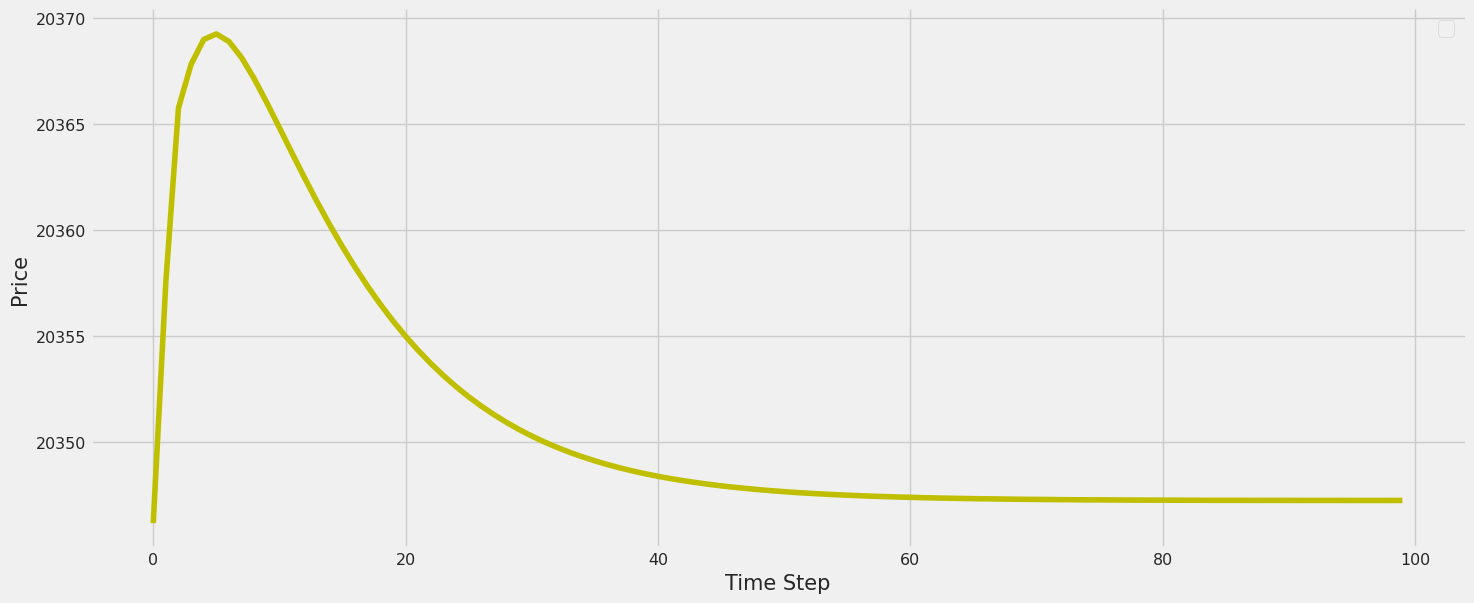

In [328]:
plt.figure(figsize=(15,6))
plt.plot(pred_100_inv, 'y')
plt.tight_layout()
sns.despine(top=True)
plt.subplots_adjust(left=0.07)
plt.ylabel('Price', size=15)
plt.xlabel('Time Step', size=15)
plt.legend(fontsize=15)
plt.show()

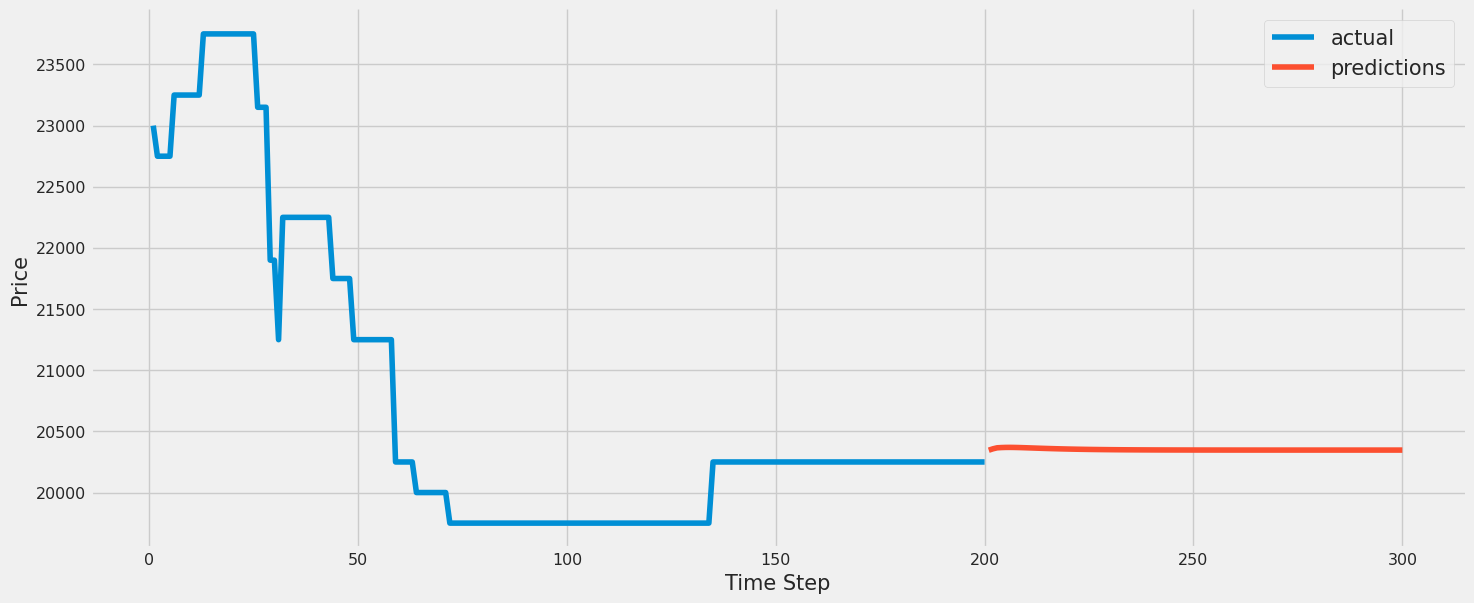

In [329]:
plt.figure(figsize=(15,6))
plt.plot(day_test, np.array(df_test['Price']), label="actual")
plt.plot(day_100, pred_100_inv.T[0], label="predictions")
plt.tight_layout()
sns.despine(top=True)
plt.subplots_adjust(left=0.07)
plt.ylabel('Price', size=15)
plt.xlabel('Time Step', size=15)
plt.legend(fontsize=15)
plt.show()